<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

***
 Магазин запускает новый сервис, который позволяет пользователям редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других, и магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
 
Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные с помощью машинного обучения. 

Задача проекта - обучить модель машинного обучения классифицировать комментарии на позитивные и негативные.

## Подготовка

In [1]:
import re
import nltk
import string
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score, make_scorer

from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from nltk.tokenize import word_tokenize

from catboost import CatBoostClassifier

from scipy.stats import randint

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('D:/datasets/toxic_comments.csv')


In [3]:
display(df.head())
display(df.info())
display(df.describe())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
m = WordNetLemmatizer()

In [6]:
def clear_lemmatize(text):
    text = text.lower() 
    re_list = re.sub(r"[^a-zA-Z']", ' ', text)
    re_list  = re.sub(r"(?:\n|\r)", " ", text)
    re_list = re_list.split()
    re_list = " ".join(re_list)
    lemm_list = nltk.word_tokenize(text)
        
    return ' '.join(m.lemmatize(i, wordnet.VERB) for i in lemm_list)

In [7]:
%%time

df['text_lemma'] = df['text'].apply(clear_lemmatize)
display(df.head())

,Unnamed: 0,text,toxic,text_lemma
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww ! he match this background colour i 'm s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , i 'm really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,`` more i ca n't make any real suggestions on ...
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."


CPU times: total: 1min 27s
Wall time: 1min 28s


<AxesSubplot:xlabel='toxic', ylabel='count'>

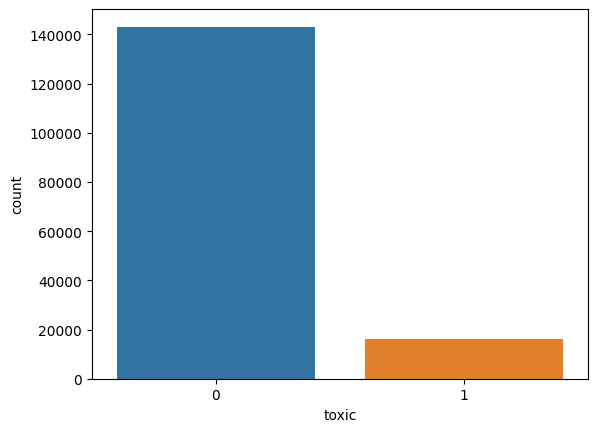

In [8]:
sns.countplot(x = 'toxic', data = df)

In [9]:
df.head(10)

,Unnamed: 0,text,toxic,text_lemma
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww ! he match this background colour i 'm s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,"hey man , i 'm really not try to edit war . it..."
3,3,"""\nMore\nI can't make any real suggestions on ...",0,`` more i ca n't make any real suggestions on ...
4,4,"You, sir, are my hero. Any chance you remember...",0,"you , sir , be my hero . any chance you rememb..."
5,5,"""\n\nCongratulations from me as well, use the ...",0,"`` congratulations from me as well , use the t..."
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word 'nonsense ' be offensive to ...
9,9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


## Обучение

In [11]:
features = df['text_lemma']
target = df['toxic']

In [8]:
train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(stop_words='english')

features_train = tfidf.fit_transform(train_data['text_lemma'])
features_val = tfidf.transform(val_data['text_lemma'])
features_test = tfidf.transform(test_data['text_lemma'])
target_train = train_data['toxic']
target_val = val_data['toxic']
target_test = test_data['toxic']

In [12]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mamay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
%%time

pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))
    )
])

param_grid = [
    {
        'model' : [LogisticRegression(random_state=12345, solver='liblinear')],
        'model__penalty' : ['l1', 'l2'],
        'model__C' : list(range(1, 15, 3))
    }
]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', 
                    cv=3, verbose=True, n_jobs=-1)
best_grid = grid.fit(features_train, target_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters is: {'model': LogisticRegression(C=4, penalty='l1', random_state=12345, solver='liblinear'), 'model__C': 4, 'model__penalty': 'l1'}
Best score is: 0.7671999916796185
CPU times: total: 859 ms
Wall time: 8.73 s


In [14]:
%%time

model_LR_1 = LogisticRegression(random_state=12345, C=4, penalty='l1', solver='liblinear', max_iter=200, class_weight = 'balanced')
model_LR_1.fit(features_train, target_train)
pred_LR_1 = model_LR_1.predict(features_val)
f1 = f1_score(target_val,pred_LR_1)
print(f"F1-score на валидационной выборке: {f1}")

F1-score на валидационной выборке: 0.7614169867690994
CPU times: total: 1.28 s
Wall time: 1.29 s


In [15]:
%%time

cat_model = CatBoostClassifier(eval_metric="F1", 
                                   iterations=100, 
                                   max_depth=6, 
                                   learning_rate=0.9, 
                                   random_state=12345)
cat_model.fit(features_train, target_train, verbose=20)
prediction = cat_model.predict(features_val)
f1 = f1_score(target_val, prediction)
print('F1 CatBoost:', f1)

0:	learn: 0.4439160	total: 513ms	remaining: 50.8s
20:	learn: 0.7372104	total: 7.66s	remaining: 28.8s
40:	learn: 0.7751129	total: 14.7s	remaining: 21.1s
60:	learn: 0.7912164	total: 21.7s	remaining: 13.9s
80:	learn: 0.8045397	total: 28.7s	remaining: 6.73s
99:	learn: 0.8188217	total: 35.3s	remaining: 0us
F1 CatBoost: 0.7568212824010914
CPU times: total: 4min 36s
Wall time: 39 s


In [9]:
%%time

model_LR_2 = LogisticRegression(random_state=12345, C=4, penalty='l1', solver='liblinear', max_iter=200)
model_LR_2.fit(features_train, target_train)
pred_LR_2 = model_LR_2.predict(features_test)
f1 = f1_score(target_test,pred_LR_2)
print(f"F1-score на валидационной выборке: {f1}")

F1-score на валидационной выборке: 0.780278302697131
CPU times: user 1.44 s, sys: 55.9 ms, total: 1.49 s
Wall time: 1.49 s


## Выводы

В данном проекте была поставлена задача классификации комментариев на позитивные и негативные с помощью машинного обучения.

Для достижения цели были выполнены следующие шаги:

Были загружены и проанализированы данные.

Была проведена предобработка данных: текст комментариев был очищен от лишних символов и токенизирован с помощью библиотеки 
nltk. 

Данные были разбиты на обучающую и тестовую выборки

Максимальное значение F1-меры было достигнуто для модели LogisticRegression - 0.09663588390501318

Были проанализированы результаты работы моделей и сделаны выводы о том, что максимальная F1-мера была достигнута для модели LogisticRegression.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>